In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns

from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('Loan_Data.csv')

In [7]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [9]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Получите базовое решение:

- 1. Удалите все пропущенные значения

- 2. Удалите все категориальные переменные

- 3. Обучите модель

- 4. Выберете и посчитайте метрику качества


In [10]:
class SimplePipeLine(BaseEstimator, TransformerMixin):
    def __init__(self, df_in, y='Loan_Status'):
        self.df = df_in.copy()
        self.name_y = y
        self.operations = (self.del_all_nan, 
                           self.change_y, 
                           self.del_all_categarial)
    
    def transform(self):
        for operation in self.operations:
            operation()
        return self.df
        
    def change_y(self):
        print(f'Заменяем строки на значения 1/0 в целевом признаке...')
        if self.df[self.name_y].dtype == 'object':
            self.df[self.name_y] = self.df[self.name_y].map(lambda x: 1 if x == 'Y' else 0)
            print(f'-> Строки заменены\n')
        else:
            print(f'- Ничего менять не надо...\n')
    
    def del_all_nan(self):
        print(f'Проводим удаление пропусков...')
        start = len(self.df)
        self.df.dropna(inplace=True)
        print(f'-> Удалено: {start - len(self.df)} строк\n')
    
    def del_all_categarial(self):
        print(f'Проводим удаление категориальных переменных...')
        categorial = self.df.select_dtypes('object').columns
        print(f'-> Найдены категориальные переменные: {len(categorial)} шт')
        self.df.drop(columns=categorial, inplace=True)
        print(f'-> Удалено: {len(categorial)} стoлбцов\n')
    

In [11]:
pipe = SimplePipeLine(df)
df_simple = pipe.transform()

Проводим удаление пропусков...
-> Удалено: 134 строк

Заменяем строки на значения 1/0 в целевом признаке...
-> Строки заменены

Проводим удаление категориальных переменных...
-> Найдены категориальные переменные: 7 шт
-> Удалено: 7 стoлбцов



In [12]:
df_simple.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
1,4583,1508.0,128.0,360.0,1.0,0
2,3000,0.0,66.0,360.0,1.0,1
3,2583,2358.0,120.0,360.0,1.0,1
4,6000,0.0,141.0,360.0,1.0,1
5,5417,4196.0,267.0,360.0,1.0,1


Разобьем данные на тренеровочную и тестовую выборки:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_simple.drop('Loan_Status', axis = 1), \
                                                    df_simple['Loan_Status'], test_size=0.33, random_state=42)

Обучим базовую модель:

In [14]:
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

LogisticRegression()

Рассчитаем показатель score метрики:

In [15]:
accuracy_train = base_model.score(X_train, y_train)
accuracy_train

0.8130841121495327

In [16]:
base_model.score(X_test, y_test)

0.7987421383647799

Показатель precission:

In [17]:
precission = fbeta_score(base_model.predict(X_test), y_test, beta = 0)
precission

1.0

Показатель recall:

In [18]:
recall = fbeta_score(base_model.predict(X_test), y_test, beta = 10000)
recall

0.7777777795061728

Показатель fscore:

In [39]:
fscore = fbeta_score(base_model.predict(X_test), y_test, beta = 1)
fscore

0.8750000000000001

In [40]:
roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1])

0.6559650455927051

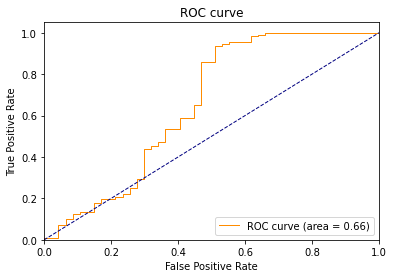

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, base_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [639]:
counts = y_train.value_counts()
counts[1] / sum(counts) # Доля целевой категории от тренеровочной выборки 

0.6853582554517134

In [73]:
counts

1    220
0    101
Name: Loan_Status, dtype: int64

In [64]:
fpr[np.argmax(tpr)] #Значение fpr при максимальном tpr

0.6595744680851063

<h3>Оценка качества базовой модели</h3>

- Базовая модель точно определяет целевую характеристику (precission = 1) 
    
- Имеет большой показатель ошибок 1 рода FPR (FPR = 0.66 при TPR = 1)

- То есть базовая модель будет детектировать всех пользователей которым можно выдать займ.
  Но при этом еще будут ложно задетектированы ~66% пользователей, которым займ давать нельзя.

Учитывая, что доля 'положительных' заемщиков в выборке более чем в 2 раза больше доли 'отказников', 
модель даже модель 'дать заем всем' дала бы лучший результат на данной выборке пользователей (TPR = 1 / FPR = 0.31).

ROC_AUC_SCORE данной модели = 0.655 (показатель качества модели - площадь под графиком ROC - кривой)


Поработаем над улучшением качеста модели.

- 1. Проведите первичный анализ данных
- 2. Проведите визуальный анализ данных
- 3. Разбейте данные на обучение и тест
- 4. Сделайте предобработку данных с помощью класса и пайплайна
- 5. Обучите модель классификации с целевым признаком Loan_Status
- 6. Оцените подходящие метрики качества
- 7. Сформулируйте выводы по проделанной работе

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [75]:
class HardPipeLine(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.operations = (self.drop_id, 
                           self.drop_na,
                          self.categorial_to_numeric,
                          self.scale)
        self.change_dict = {}
        self.df = None
    
    def fit(self, df: pd.DataFrame):
        self.df = df.copy()
        
    def transform(self):
        for operation in self.operations:
            operation()
   
    def drop_id(self):
        print(f'Удаляем колонки с ID...')
        
        self.df.drop('Loan_ID', axis = 1, inplace=True)
        
        print(f'-> Колонка Loan_ID удалена\n')
    
    def categorial_to_numeric(self):
        # Функция делает тоже, что и Lebel Encoding - тут для тренеровки.
        
        print(f'Заменяем категориальные переменные на числовые...')
        
        categorial = self.df.select_dtypes('object')
        
        for column in categorial:
            self.change_dict[column] = {}
            for counter, el in enumerate(categorial[column].unique()):
                self.change_dict[column][el] = counter
            self.df[column] = categorial[column].map(lambda x: self.change_dict[column][x])
            
        print(f'-> Собран словарь для замены строк значениями\n')
        
        for el in self.change_dict:
            print(f'{el}: {self.change_dict[el]}')
            
        print()
        print(f'-> Проведена замена строк значениями в df по словарю выше\n')
    
    def drop_na(self):
        print(f'Удаляем строки с пустыми значениями...')
        
        start = len(self.df)
        self.df.dropna(inplace=True)
        
        print(f'-> Удалено: {start - len(self.df)} строк данных с пропусками\n')
    
    def scale(self):
        #Ручной min / max scaller
        
        print(f'Масштабируем данные в формате min/max масштабирования...')
        
        self.df = self.df.round(3)/(self.df.max(axis=0) - self.df.min(axis=0)).round(2)
        
        print(f'-> Данные масштабированы')
    

In [76]:
pipe1 = HardPipeLine()
pipe1.fit(df)
pipe1.transform()
pipe1.df.head()


Удаляем колонки с ID...
-> Колонка Loan_ID удалена

Удаляем строки с пустыми значениями...
-> Удалено: 134 строк данных с пропусками

Заменяем категориальные переменные на числовые...
-> Собран словарь для замены строк значениями

Gender: {'Male': 0, 'Female': 1}
Married: {'Yes': 0, 'No': 1}
Dependents: {'1': 0, '0': 1, '2': 2, '3+': 3}
Education: {'Graduate': 0, 'Not Graduate': 1}
Self_Employed: {'No': 0, 'Yes': 1}
Property_Area: {'Rural': 0, 'Urban': 1, 'Semiurban': 2}
Loan_Status: {'N': 0, 'Y': 1}

-> Проведена замена строк значениями в df по словарю выше

Масштабируем данные в формате min/max масштабирования...
-> Данные масштабированы


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,0.0,0.0,0.000000,0.0,0.0,0.056685,0.044567,0.216582,0.810811,1.0,0.0,0.0
2,0.0,0.0,0.333333,0.0,1.0,0.037106,0.000000,0.111675,0.810811,1.0,0.5,1.0
3,0.0,0.0,0.333333,1.0,0.0,0.031948,0.069687,0.203046,0.810811,1.0,0.5,1.0
4,0.0,1.0,0.333333,0.0,0.0,0.074212,0.000000,0.238579,0.810811,1.0,0.5,1.0
5,0.0,0.0,0.666667,0.0,1.0,0.067001,0.124006,0.451777,0.810811,1.0,0.5,1.0


In [77]:
df_hard = pipe1.df
df_hard.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,0.0,0.0,0.000000,0.0,0.0,0.056685,0.044567,0.216582,0.810811,1.0,0.0,0.0
2,0.0,0.0,0.333333,0.0,1.0,0.037106,0.000000,0.111675,0.810811,1.0,0.5,1.0
3,0.0,0.0,0.333333,1.0,0.0,0.031948,0.069687,0.203046,0.810811,1.0,0.5,1.0
4,0.0,1.0,0.333333,0.0,0.0,0.074212,0.000000,0.238579,0.810811,1.0,0.5,1.0
5,0.0,0.0,0.666667,0.0,1.0,0.067001,0.124006,0.451777,0.810811,1.0,0.5,1.0


In [78]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_hard.drop('Loan_Status', axis = 1), \
                                                    df_hard['Loan_Status'], test_size=0.33, random_state=42)

In [79]:
model2 = LogisticRegression()
model2 = model2.fit(X_train2, y_train2)

Рассчитаем показатель score метрики:

In [80]:
accuracy_train2 = model2.score(X_train2, y_train2)
accuracy_train2

0.8130841121495327

In [81]:
model2.score(X_test2, y_test2)

0.7987421383647799

Показатель precission:

In [58]:
precission2 = fbeta_score(model2.predict(X_test2), y_test2, beta = 0)
precission

1.0

Показатель recall:

In [59]:
recall = fbeta_score(model2.predict(X_test2), y_test2, beta = 10000)
recall

0.7777777795061728

Показатель fscore:

In [60]:
fscore2 = fbeta_score(model2.predict(X_test2), y_test2, beta = 1)
fscore2

0.8750000000000001

In [61]:
roc_auc_score(y_test2, model2.predict_proba(X_test2)[:, 1])

0.8106003039513677

<h3>Промежуточные выводы </h3>

- Метрики precission, recall (соответственно и f-score) не изменились.

    Модель по-прежнему определеяет примерно 78% всех 'положительных' клиентов с 100% точностью.
    
- Такой высокий показатель не гарантирует качество модели, так как выборка не сбалансирована.

Однако для применения в 'поле' конкретно к поставленной задаче, 

нам важно не найти всех 'одобряемых' клиентов.

Нам нужно найти максимальное количество 'положительных' при минимальном количестве ложных сробатываний под 'отказников'.

Для этого мы и улучшали модель.

roc_auc_score = новой модели 0,811 (против 0,66 первой)

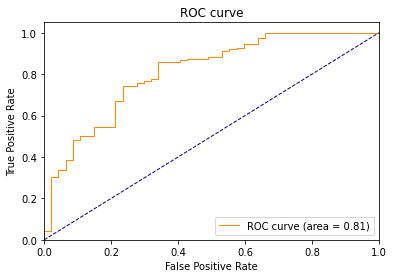

In [604]:
fpr2, tpr2, thresholds2 = roc_curve(y_test2, model2.predict_proba(X_test2)[:, 1])
roc_auc2 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [605]:
roc_auc2

0.8106003039513677

<h3>Настройка модели под задачу</h3>

- В зависимости от кредитной политики, занимаемой доли рынка, ключевй ставки, % взыскания долгов (и еще сотни параметров)
  кредитная организация определяет приемлимую максимальную долю 'неплательщиков'. Это будет максимальный приeмлимый FPR.
  
  
- Таким образом, чем выше качество модели, тем большую долю 'плательщиков' мы можем детектировать не привышая допустимый порог ошибки.




В целом, мы не знаем пороговое значение FPR в конкретном кейсе, но можем построить график изменения разницы TPR - FPR как целевой функции и предложить несколько вариантов тюнинга модели под конкретные задачи.

Определим лучшие точки тюнинга модели:

Определим максимальный тангенс угла прямой последовательно из каждой следующей точки. Следующую начальную точку выбираем как точку с макимальным тангенсом в прошлой итерации. Таким образом получим оптимальные точки подстройки нашей модели для определенных интервалах. Чем более выпукалая и плавная кривая TPR - FPR по форме  - тем более плавно можно регулировать настойку модели. Каждую точку определим порядковым номером случая и представим их на графике.

In [635]:
diff_base = tpr2 - fpr2

In [636]:
# Итерируемся по точкам: каждая следующая - точка с максимальным тангенсом. 
# Проходимся до tg >= 0 т.к. нас не интересует убывающий участок графика.

best_tg_list = [] # список максимальных tg
best_diff_list = [] # Список максимальных 
best_fpr_list = []

temp_fpr = min(fpr2) # Начальные точка FPR обхода
temp_diff = diff_base[fpr2.argmin()] # Начальная точка DIFF обхода
for _ in diff_base:
    fpr_f = fpr2[fpr2 > temp_fpr]
    diff_f = diff_base[fpr2 > temp_fpr]
    tg_temp = (diff_f -  temp_diff) / (fpr_f - temp_fpr)
    if max(tg_temp) >= 0:
        best_tg_list.append(max(tg_temp))
        best_diff_list.append(diff_f[tg_temp.argmax()])
        best_fpr_list.append(fpr_f[tg_temp.argmax()])
        temp_fpr = best_fpr_list[-1]
        temp_diff = best_diff_list[-1]
    else:
        break


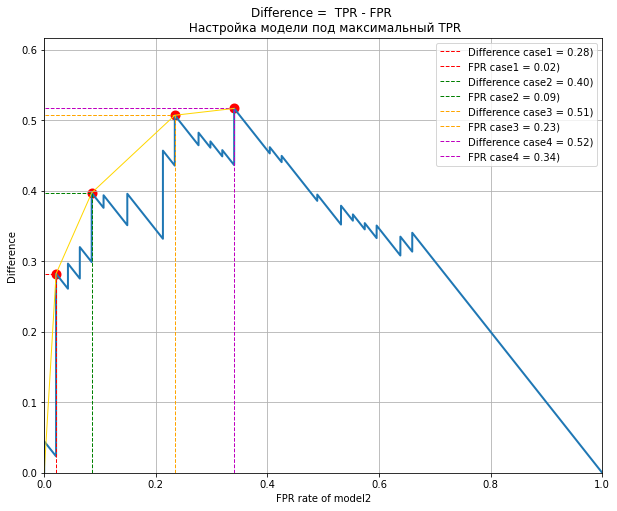

In [638]:
plt.figure(figsize=(10, 8))
plt.grid()
plt.plot(fpr2, diff, lw=2)
counter = 0
for F, D, col in zip(best_fpr_list, best_diff_list, ['r', 'g', 'orange','m', 'p', 'b']):
    counter += 1
    plt.plot([0.001, F], [D, D],  color=col, lw=1, 
         linestyle='--', label=f'Difference case{counter} = %0.2f)' % D)
    
    plt.plot([F, F], [0, D],  color=col, lw=1, 
         linestyle='--', label=f'FPR case{counter} = %0.2f)' % F)
    
plt.scatter(best_fpr_list, best_diff_list, color='red', lw=4)

plt.plot([0, *best_fpr_list], [0, *best_diff_list], color='gold', lw = 1)

plt.xlim([0.0, 1])
plt.ylim([0.0, max(diff) + 0.1])
plt.xlabel('FPR rate of model2')
plt.ylabel('Difference')
plt.title('Difference =  TPR - FPR \n Настройка модели под максимальный TPR')
plt.legend(loc="upper right")
plt.show()

<h4>1 сценарий: 'Нулевой терпимости к невыплатам':</h4>

Может быть актуально при большом количестве заявок от неплательщиков и малом количестве заявок от платящих клиентов.

FPR ~ 0.02

TPR ~ 0.3

По этому сценарию будут найдены и выданы всего 30% от всех потоенциальных 'хороших' клиентов,

но при этом всего 2% от всех возможных 'неплательщиков' попадут в кредитный портфель.

<h4>2 сценарий: 'Консервативный':</h4>

Мы стараемся минимизировать ошибки, но охватываем большую долю плательщиков

FPR ~ 0.09

TPR ~ 0.48

По этому сценарию будут найдены всего 48% от всех потоенциальных 'хороших' клиентов,

но при этом 8% от всех возможных 'неплательщиков' попадут в кредитный портфель.

<h4>3 сценарий 'Лояльный':</h4>

Отмечен на графике выше:

FPR ~ 0.23

TPR ~ 0,74

То есть мы выдадим кредит успешно определив 74% от всех возможных искомых клиентов.
При этом прокредитуем 23% неплательщиков.


<h4>4 сценарий 'Максимальных выдач':</h4>

Отмечен на графике выше:

FPR ~ 0.34

TPR ~ 0,86

То есть мы выдадим кредит успешно определив 86% от всех возможных искомых клиентов.
При этом прокредитуем 34% неплательщиков.

Такой сценарий подойдет когда в кредитной организации большой процент возврата средств от неплательщиков, или
просто количество заявок от потенциальных неплательщиков кратно меньше количества заявок от платящей группы клиентов.
Например, выдаем кредиты только своим сотрудникам.


Чтобы выбрать настройку, надо понимать доход с 1 плательщика и убытки с 1 неплательщика. На эти показатели влияет большое количество иных метрик. Чтобы что-то выбрать для настройки, сделаем ряд предположений:

 - Распределение клиентов в выборке соответствует общей картине на рынке (то есть соотношение плательщик/неплательщик соответствует среднерыночному и неизменно, что точно не так, но других данных нет)
 - Допустим, чистый доход с 1 платящего клиента 5% (за вычетом расходов на его администрирование, ключевую ставки и т.д)
 - Пусть чистый убыток с 1 неплатащего клиента 20%
 
 Тогда можем выбрать лучший сценарий для наших исторических данных:
 

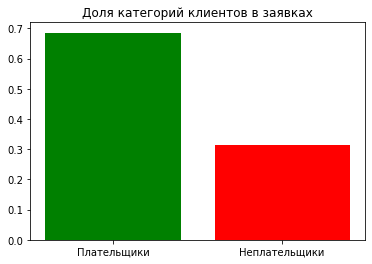

In [668]:
counts = y_train.value_counts()
good = counts[1] / sum(counts)
bad = counts[0] / sum(counts)

plt.figure(figsize=(6, 4))
plt.bar(['Плательщики', 'Неплательщики'],[good, bad], color = ['green', 'red'])
plt.title('Доля категорий клиентов в заявках')
plt.show()

In [728]:
income = 0.05 * (np.array(best_diff_list) * good + np.array(best_fpr_list)) -  0.2 * np.array(best_fpr_list) * bad

In [729]:
income

array([0.00939858, 0.01250533, 0.01434904, 0.01330568])

In [736]:
final_FPR = best_fpr_list[income.argmax()]
final_TPR = best_diff_list[income.argmax()] + final_FPR

In [737]:
final_FPR # Выбранный показатель FPR (case 3)

0.23404255319148937

In [738]:
final_TPR # Выбранный показатель TPR (case 3)

0.7410714285714286

In [769]:
# Граница разделения категорий
treshhold_final = max(thresholds2[fpr2 == final_FPR])
treshhold_final

0.786380986391785

In [764]:
from sklearn.metrics import classification_report

In [774]:
# Если вероятность попадания в категорию меньше границы вероятности - относим к неплательщикам.
predict = model2.predict_proba(X_test2)[:, 1]
predict = np.where(predict < treshhold_final, 0, 1)

In [775]:
# Финальные показатели на тесте
print(classification_report(y_test2, predict))

              precision    recall  f1-score   support

         0.0       0.49      0.77      0.60        47
         1.0       0.87      0.67      0.76       112

    accuracy                           0.70       159
   macro avg       0.68      0.72      0.68       159
weighted avg       0.76      0.70      0.71       159



<h4> Ответ по работе: </h4>

 - Обучил базовую модель, рассмотрел характеристики ROC_AUC базовой модели.
 - Провел подготовку данных, трансформировал данные.
 - Обучил модель 2. Улучшил характеристику ROC_AUC score
 - Выбрал харатеристику оптимизации модели для поставленной задачи.
 - Нашел 4 оптимальные точки настройки модели под различные сценарии.
 - Предположил 1 из сценариев, перенастроил модель, переместив границу разделеия в соответствии со сценарием.